In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import pandas as pd
from socc_har.data import DataModule
from socc_har.eval import ReportEvaluationModule

data_path = '../data'
out_path='.'
metadata_file=None
num_frames = 32
res = 224
fps=12

dm = DataModule(database='socc-har-32-v0.1.1',
                data_dir=data_path, out_dir=out_path,
                num_frames=num_frames,
                res=res, fps=fps,
                #batch_size=multi_clip_test_bs if consensus != 'pool' else single_clip_test_bs,
                max_train_samples_per_class=200,
                metadata_path=metadata_file,
                #test_duration=test_clip_duration,
                #num_test_crops=num_test_crops if consensus != 'pool' else 1,
                #num_test_frames=num_test_frames if consensus == 'pool' else None
                )

db = dm.database


In [10]:
eval = ReportEvaluationModule('.', dm, pd.read_csv(f'./cluster/csn_best.csv'), None, ['png', 'eps'])
_, ba = eval.get_scalar_by_class('test', 'balanced_accuracy', True)
_, f1 = eval.get_scalar_by_class('test', 'f1', True)
_, au = eval.get_scalar_by_class('test', 'auroc', True)
_, _ = eval.get_pca_by_class('test', True)

In [159]:
import torch
metric_cube = torch.zeros((32, 5))

_, ba = eval.get_scalar_by_class('test', 'balanced_accuracy', False)
_, f1 = eval.get_scalar_by_class('test', 'f1', False)
_, pr = eval.get_scalar_by_class('test', 'precision', False)
_, re = eval.get_scalar_by_class('test', 'recall', False)
_, au = eval.get_scalar_by_class('test', 'auroc', False)

metric_cube[:, 0] = torch.stack(list(ba.values()))
metric_cube[:, 1] = torch.stack(list(f1.values()))
metric_cube[:, 2] = torch.stack(list(pr.values()))
metric_cube[:, 3] = torch.stack(list(re.values()))
metric_cube[:, 4] = torch.FloatTensor(list(au.values()))

tensor([[0.5718, 0.0195, 0.0103, 0.1667, 0.7708],
        [0.5481, 0.0345, 0.0202, 0.1167, 0.7926],
        [0.6945, 0.0330, 0.0172, 0.4375, 0.8175],
        [0.5000, 0.0000, 0.0000, 0.0000, 0.7559],
        [0.7345, 0.1177, 0.0661, 0.5395, 0.8047],
        [0.5218, 0.0741, 0.2308, 0.0441, 0.9230],
        [0.9426, 0.4746, 0.3205, 0.9143, 0.9775],
        [0.6845, 0.4593, 0.5809, 0.3798, 0.9251],
        [0.5000, 0.0000, 0.0000, 0.0000, 0.7215],
        [0.5000, 0.0000, 0.0000, 0.0000, 0.8027],
        [0.7351, 0.0355, 0.0183, 0.5938, 0.7914],
        [0.8220, 0.5441, 0.4603, 0.6651, 0.9516],
        [0.5943, 0.2738, 0.4340, 0.2000, 0.7971],
        [0.6782, 0.3322, 0.2874, 0.3934, 0.8307],
        [0.8979, 0.2037, 0.1159, 0.8393, 0.9701],
        [0.8630, 0.2448, 0.1444, 0.8030, 0.9352],
        [0.4994, 0.0000, 0.0000, 0.0000, 0.6464],
        [0.6672, 0.2768, 0.2331, 0.3407, 0.9482],
        [0.8184, 0.0931, 0.0499, 0.6875, 0.8997],
        [0.5000, 0.0000, 0.0000, 0.0000, 0.7784],


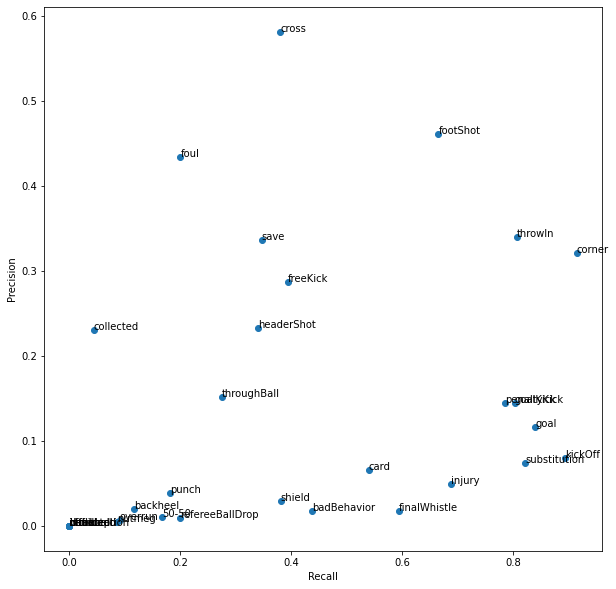

In [168]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))
recall = list(re.values())
precision = list(pr.values())
ax.scatter(recall, precision)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')

for idx, cls in enumerate(dm.classes):
    plt.annotate(cls, (recall[idx], precision[idx]))

fig.savefig('/Users/simonnarendorf/Documents/Projects/soccer-action-classification/Thesis/img/07_precision_recall_by_class.eps', format='eps')


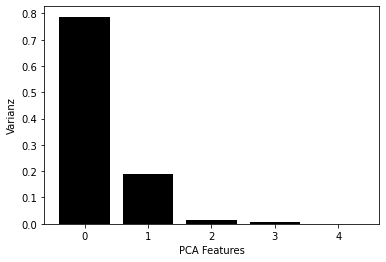

In [167]:
from sklearn.decomposition import PCA

fig, ax = plt.subplots()
pca = PCA(n_components=5)
#pca.fit(metric_cube)
principalComponents = pca.fit_transform(metric_cube)

features = range(pca.n_components_)
ax.bar(features, pca.explained_variance_ratio_, color='black')
ax.set_xlabel('PCA Features')
ax.set_ylabel('Varianz')
ax.set_xticks(features)

fig.savefig('/Users/simonnarendorf/Documents/Projects/soccer-action-classification/Thesis/img/07_pca_components.eps', format='eps')



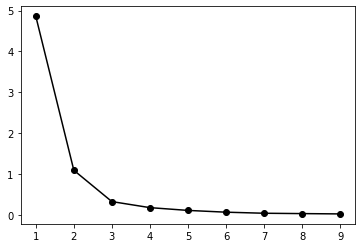

In [107]:
PCA_components = pd.DataFrame(principalComponents)

ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)

    # Fit model to samples
    model.fit(PCA_components.iloc[:,:1])

    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel = 'number of clusters, k'
plt.ylabel = 'inertia'
plt.xticks(ks)
plt.show()


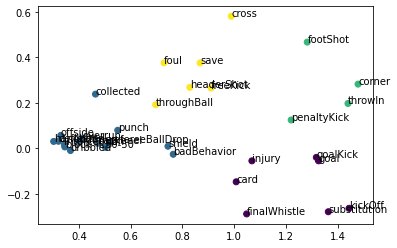

In [93]:
components = pca.components_
components = torch.Tensor(components).transpose(1, 0)
projection = torch.matmul(metric_cube, components)
projection.size()


model = KMeans(n_clusters=4)
model.fit(PCA_components.iloc[:,:3])
plt.scatter(projection[:,0], projection[:,1], c=model.labels_.astype(float))

for idx, cls in enumerate(dm.classes):
    if projection[idx,0] > 0.5 or projection[idx,1] > -0.3:
        plt.annotate(cls, (projection[idx,0], projection[idx,1]))

tensor([[0.3815, 0.3321, 0.2271, 0.8111, 0.1863]])
tensor([0.5057, 0.4674, 0.7870, 0.3315, 0.9218, 0.4838, 1.5136, 1.0260, 0.3251,
        0.3403, 0.9254, 1.3156, 0.7269, 0.9081, 1.2980, 1.2689, 0.3109, 0.8523,
        1.0797, 0.3357, 1.3222, 0.4126, 0.3448, 0.4310, 1.2752, 0.5717, 0.5440,
        0.9011, 0.7628, 1.2262, 0.7217, 1.3922])


<AxesSubplot:title={'center':'PCA-0'}>

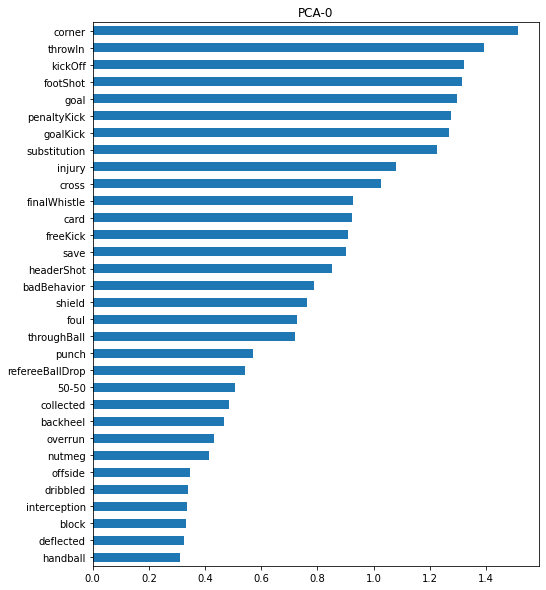

In [175]:
from sklearn.cluster import KMeans

pca = PCA(n_components=1)
pca.fit(metric_cube)

print(torch.Tensor(pca.components_))

components = torch.Tensor(torch.Tensor(pca.components_)[0,:])#
projection = torch.matmul(metric_cube, components)
projection.size()
print(projection)


model = KMeans(n_clusters=5)
model.fit(projection.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(8, 10))
PCA_df = pd.DataFrame({'pca_0': projection}, index=dm.classes).sort_values(by=['pca_0'], ascending=True)
PCA_df.plot.barh(ax=ax, legend=False, title='PCA-0')
#ax.legend(False)


In [140]:
model.labels_

print([cls for idx, cls in enumerate(dm.classes) if model.labels_[idx] == 0])
print([cls for idx, cls in enumerate(dm.classes) if model.labels_[idx] == 1])
print([cls for idx, cls in enumerate(dm.classes) if model.labels_[idx] == 2])

['corner', 'footShot', 'goal', 'goalKick', 'kickOff', 'penaltyKick', 'substitution', 'throwIn']
['50-50', 'backheel', 'block', 'collected', 'deflected', 'dribbled', 'handball', 'interception', 'nutmeg', 'offside', 'overrun', 'punch', 'refereeBallDrop']
['badBehavior', 'foul', 'headerShot', 'save', 'shield', 'throughBall']
